# Lab 4
Lucas Street, 1874989

In [9]:
%%capture
import sys
!{sys.executable} -m pip install --user scipy numpy matplotlib pandas h5py
from multiprocessing import Pool

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import scipy as sp
import pandas as pd
import h5py
from scipy import stats
from scipy.optimize import curve_fit

## Problem 1

We have about 2.6 million data points representing 30 days of measurements from a gamma-ray satellite, along with associated metadata, like the time of the measurement, the solar phase, and the longitude of the satellite relative to Earth. Each measurement represents the number of counts seen in a 0.1 second interval. Since we don't see gamma rays _that_ often, most of these counts are cosmic rays.

In [10]:
with h5py.File('gammaray_lab4.h5', 'r') as hf:
    data = np.array(hf.get('data'))

We'll plot the first 300,000 measurements to see what the data generally looks like:

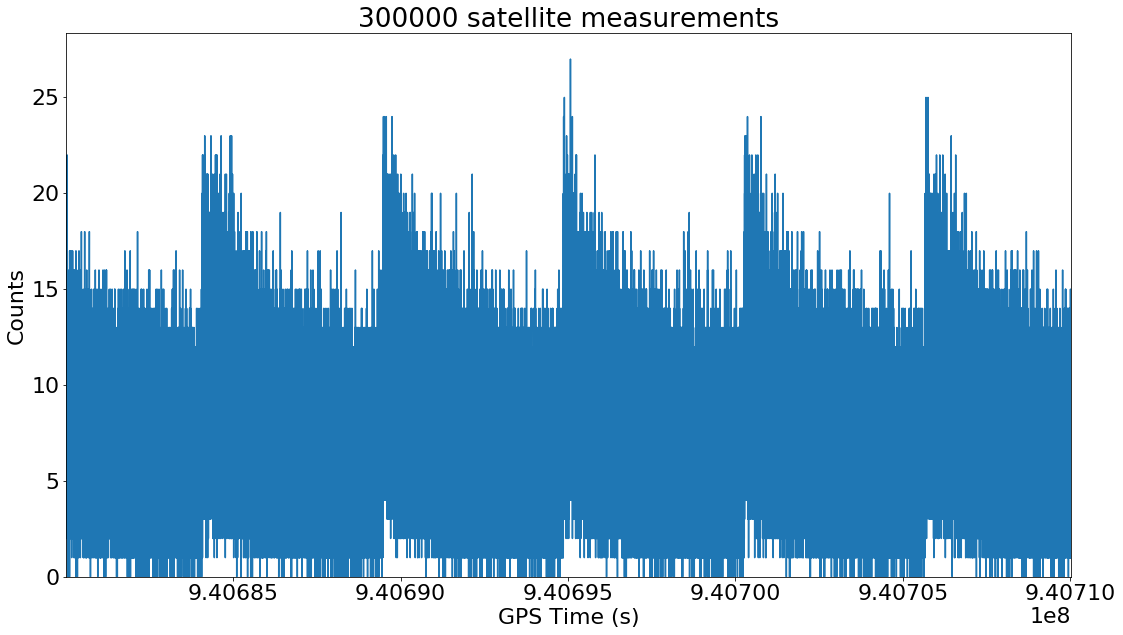

In [11]:
num_points = 300_000
plt.title(f"{num_points} satellite measurements")
plt.xlabel('GPS Time (s)')
plt.ylabel('Counts')
plt.plot(data[0][0:num_points], data[3][0:num_points]);
plt.xlim(data[0][0], data[0][num_points])
plt.ylim(0, None);

Clearly, the data is not random, since we see periodic "jumps" in the measurements. Let's plot a normalized histogram of this data:

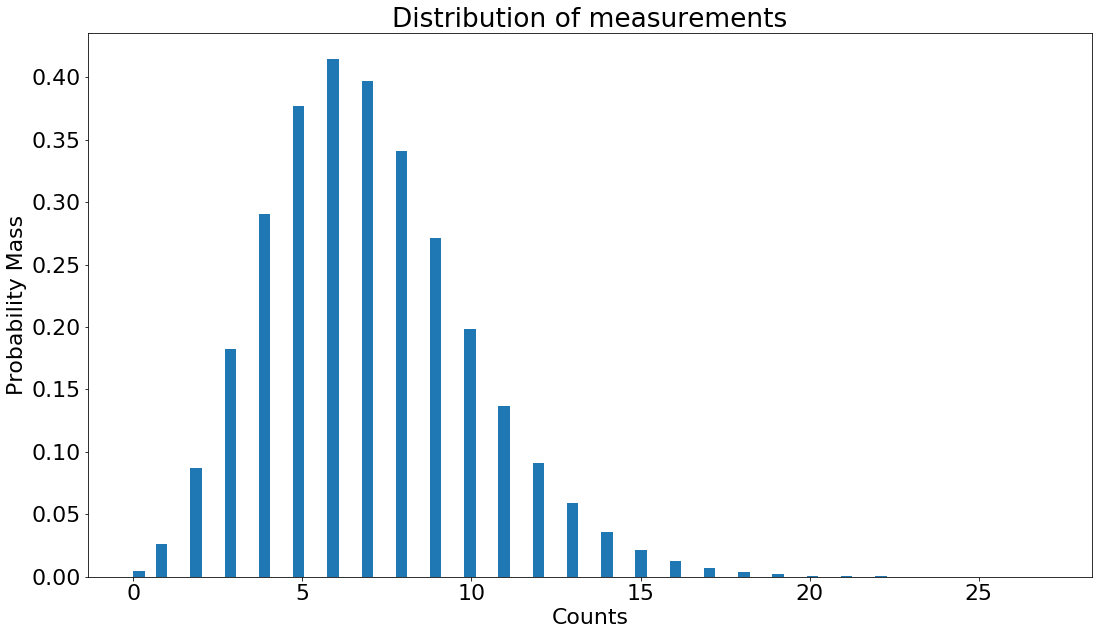

In [12]:
plt.title('Distribution of measurements')
plt.xlabel('Counts')
plt.ylabel('Probability Mass')
plt.hist(data[3][0:num_points], bins=80, density=True);

Looks fairly Poisson-like, with a mean of around 6 counts per 0.1 sec. What about when this data is viewed on a log scale with a Poisson alongside for comparison?

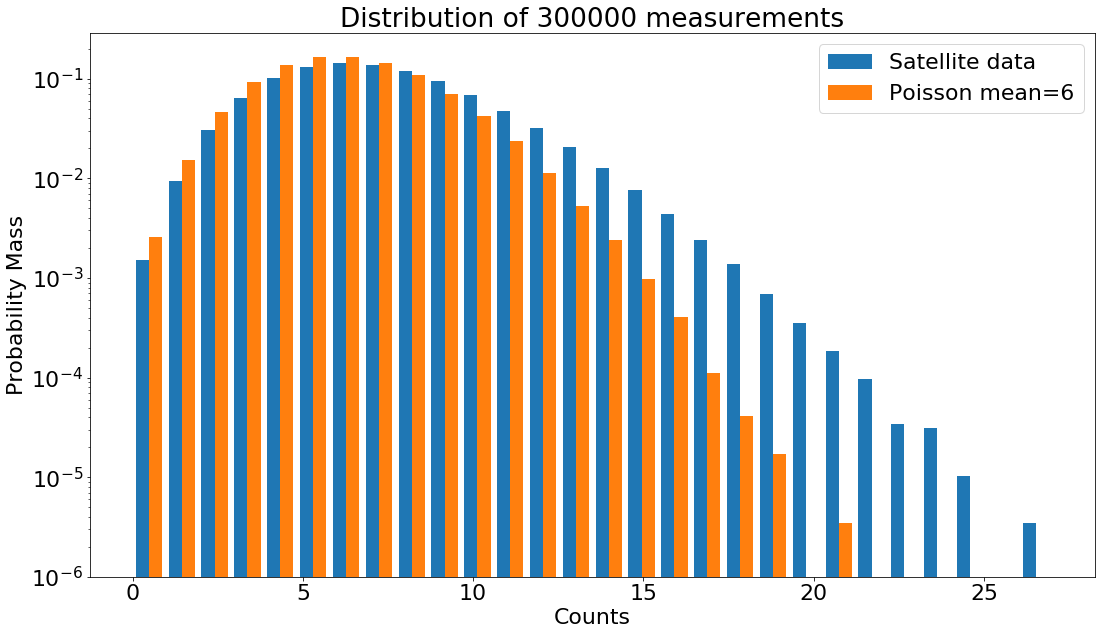

In [13]:
plt.title(f"Distribution of {num_points} measurements")
plt.xlabel('Counts')
plt.ylabel('Probability Mass')

dist = stats.poisson(6)
vals = dist.rvs(num_points)
plt.hist([data[3][0:num_points], vals], bins=28, density=True)

plt.yscale('log')
plt.ylim(1e-6, None)
plt.legend(['Satellite data', 'Poisson mean=6']);

Definitely not Poisson-distributed - the right tail is too long, and the leftmost bins are lower in probability. This makes sense when examining the data - the "jumps" we see on the signal plot periodically show more counts at values further above the mean, which, at the same time, reduces the number of low-count measurements.

There appears to be some signal contamination. Let's look at some of the metadata to see what might be going on.

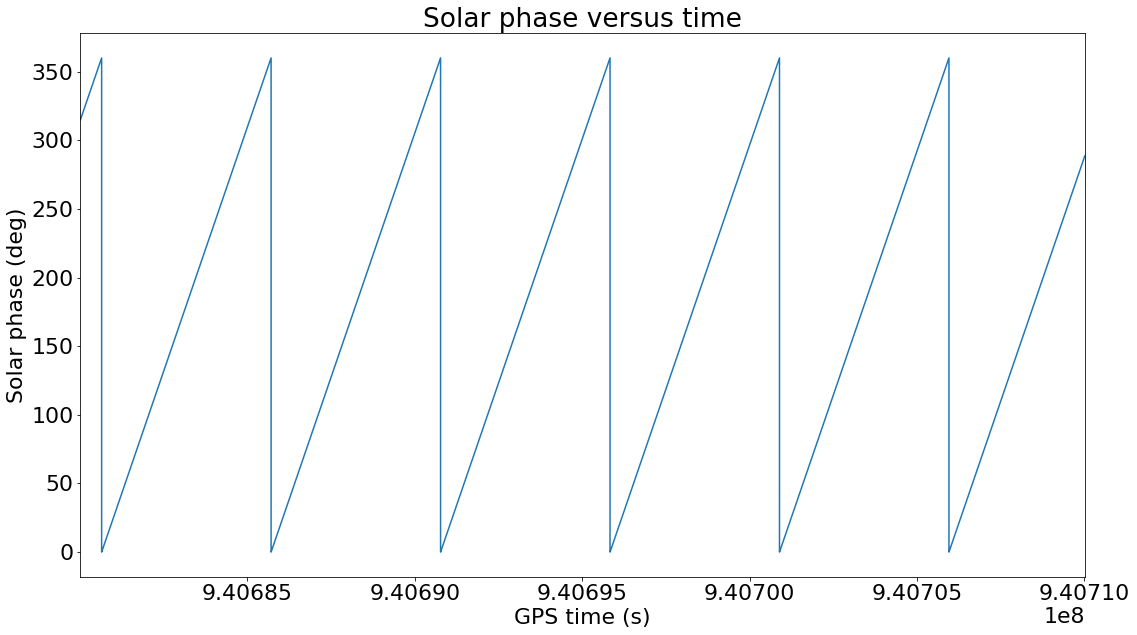

In [14]:
plt.title('Solar phase versus time')
plt.xlabel('GPS time (s)')
plt.ylabel('Solar phase (deg)')
plt.plot(data[0][0:num_points], data[1][0:num_points])
plt.xlim(data[0][0], data[0][num_points]);

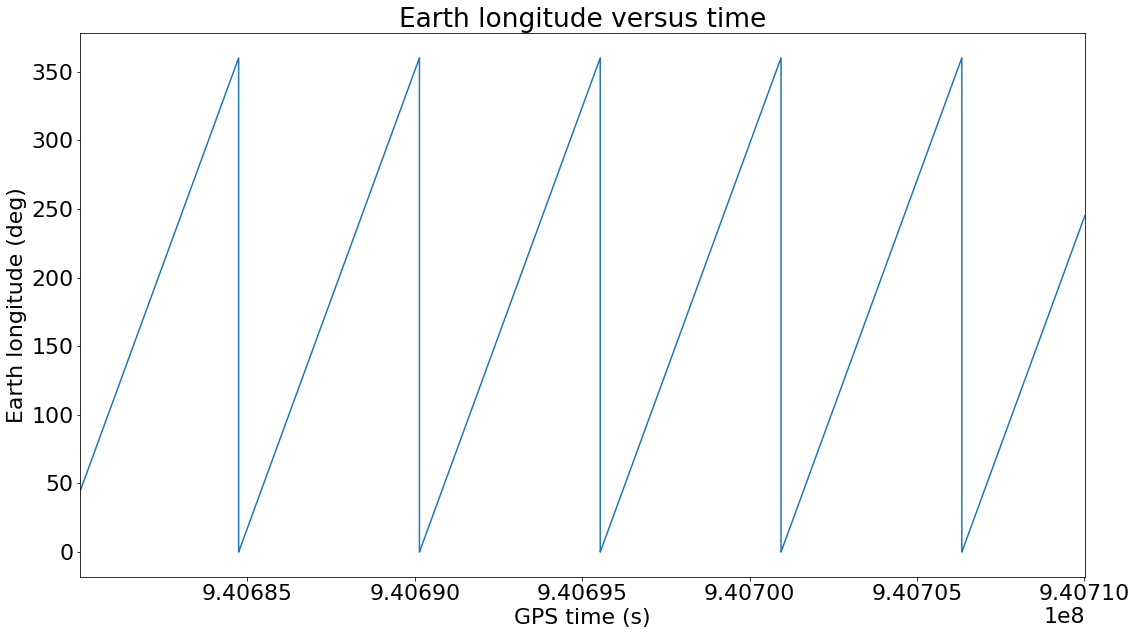

In [15]:
plt.title('Earth longitude versus time')
plt.xlabel('GPS time (s)')
plt.ylabel('Earth longitude (deg)')
plt.plot(data[0][0:num_points], data[2][0:num_points])
plt.xlim(data[0][0], data[0][num_points]);

Aha - the angular positions of the sun and satellite relative to the earth seem to follow a similar "spiking" pattern. Let's plot the raw measurements underneath plots of the metadata over time and see if we can spot any patterns.

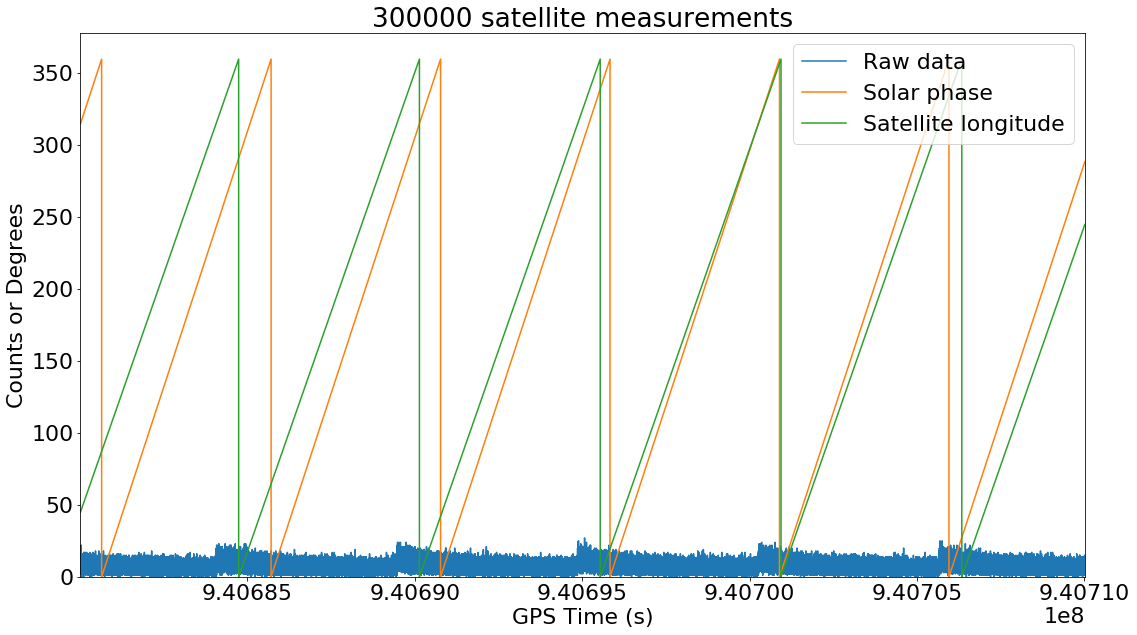

In [16]:
plt.title(f"{num_points} satellite measurements")
plt.xlabel('GPS Time (s)')
plt.ylabel('Counts or Degrees')
plt.plot(data[0][0:num_points], data[3][0:num_points])
plt.plot(data[0][0:num_points], data[1][0:num_points])
plt.plot(data[0][0:num_points], data[2][0:num_points])
plt.xlim(data[0][0], data[0][num_points])
plt.ylim(0, None)
plt.legend(['Raw data', 'Solar phase', 'Satellite longitude'], loc='upper right');

The satellite longitude seems to line up pretty consistently with the periodic spikes in our data, albeit slightly shifted in phase. Every time the satellite is located at a longitude of about 325 degrees, we get a spike in counts.

## Problem 2